In [2]:
#Align and crop face
import cv2
import pandas as pd
from helpers.face import Face
from helpers.image_reader import read_image
from preprocessors.asymmetry_calculator import process_all_face

group_directories = {'PD','HC'}
group_directory = 'PD'
output_signal_folder = f'./data/working/'
version = 'v3'


In [33]:
import joblib
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from helpers.feature_selection import select_features_PCA, select_features_RFE
from helpers.load_data_subject_csv import create_dataset


parkinson_df, control_df = create_dataset(output_signal_folder, 'PD', 'HC')
data = pd.concat([parkinson_df, control_df], axis=0)
data = data.sample(frac=1,random_state=30)
#Create dataset for train
data = data.set_index('user')
X = data.drop(['label'], axis=1)
y = data['label']
X = X.fillna(method='backfill')


X, selected_features_mask = select_features_RFE(X, y,7)
selected_feature_names = X.columns
joblib.dump(selected_feature_names, f'models/selected_features_{version}.pkl')


model_placeholder = Pipeline([
    # ('scaler', StandardScaler()),
    #('feature_selection', feature_selection),  # Corrected to f_classif
    ('model', LogisticRegression())  # Placeholder for the model
])

# Define the parameter grid
param_grid = [
    # Logistic Regression
    {
        'model': [LogisticRegression(max_iter=10000)],
        'model__C': [0.1, 1, 10],
    },
    # Random Forest Classifier
    {
        'model': [RandomForestClassifier()],
        'model__n_estimators': [100, 200],
        'model__max_features': ['log2', 'sqrt'],
    },
    # SVC
    {
        'model': [SVC()],
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf'],
    },
    #DecisionTreeClassifier
    {
        'model': [DecisionTreeClassifier()],
        'model__max_depth': [5,10,15],
    }
]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
grid_search = GridSearchCV(model_placeholder, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)
# Now, to access the best estimator and its parameters:
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Predict on the test set using the best model
y_pred = best_model.predict(X_test)

# Calculate and print the accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Set: {accuracy}")

C:\Users\atefe\AppData\Local\Temp\ipykernel_68448\2895000236.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='backfill')
d:\Codes\Python\FacialAsymmetry\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Codes\Python\FacialAsymmetry\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'model': SVC(), 'model__C': 0.1, 'model__kernel': 'rbf'}
Accuracy on Test Set: 0.8611111111111112


In [34]:
#Save the model
joblib.dump(best_model , f'models/best_model_{version}.pkl')

['models/best_model_v3.pkl']

In [30]:
import numpy as np
indexes = np.where(y_pred != y_test)
#print user column of y_test where the prediction is wrong
y_test.iloc[indexes]


user
signal_PD_cropped_07_Face_1-output    1
signal_PD_cropped_18_Face_1-output    1
signal_PD_cropped_05_Face_1-output    1
signal_PD_cropped_26_Face_1-output    1
signal_PD_cropped_19_Face_1-output    1
Name: label, dtype: int64

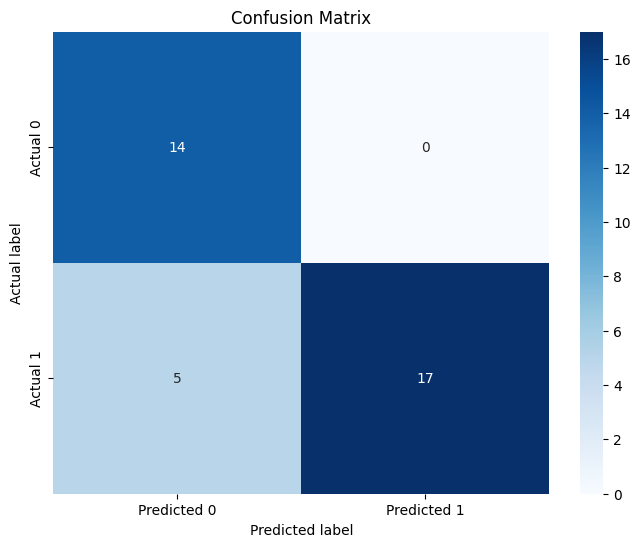

Accuracy: 0.8611
Precision: 1.0000
Recall: 0.7727
F1 Score: 0.8718


In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

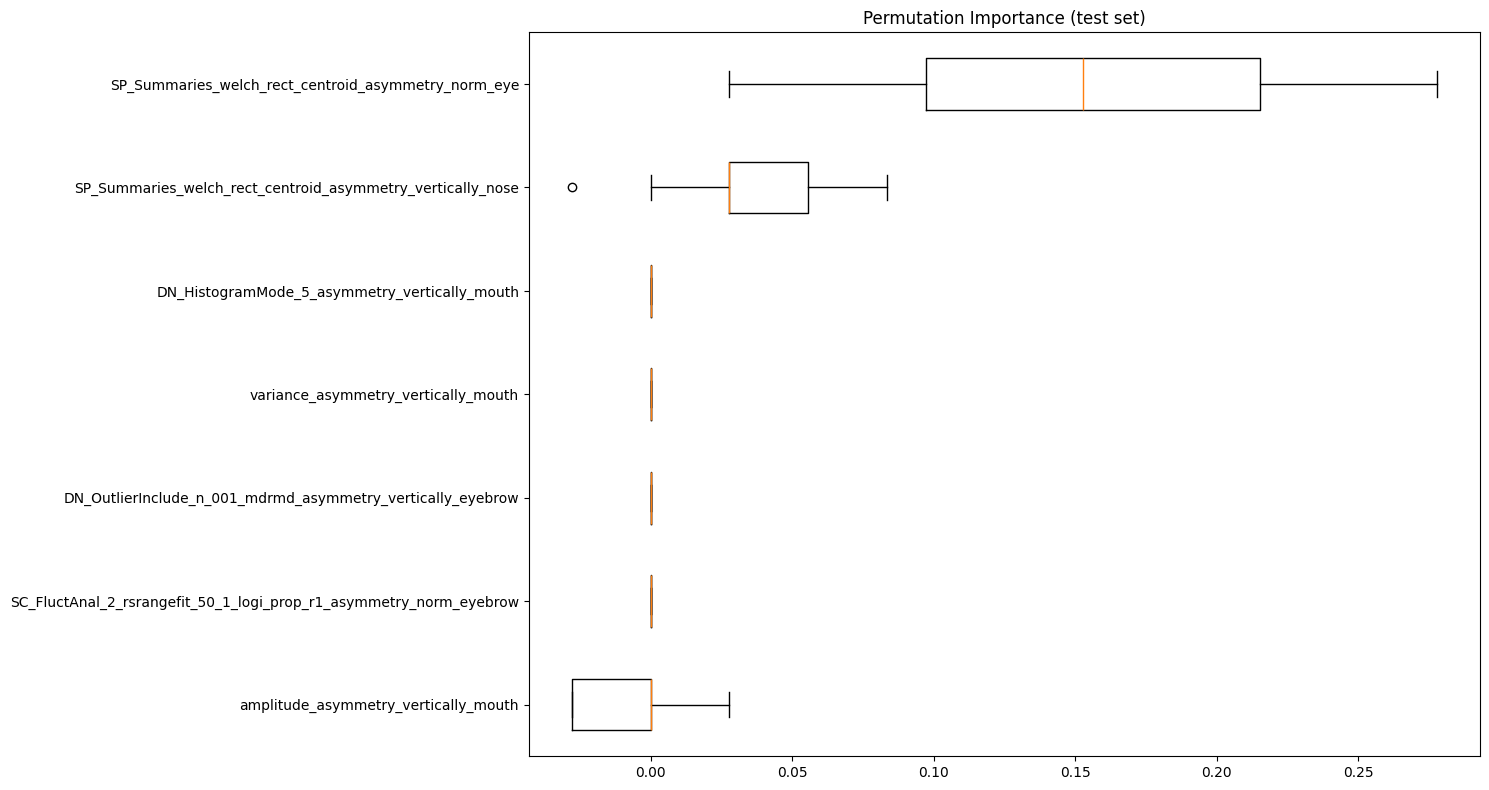

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np
# Example: Using the Iris dataset
from sklearn.datasets import load_iris

# Compute permutation feature importance
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Plot the importances
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(15,8))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(selected_feature_names)[sorted_idx])
plt.title("Permutation Importance (test set)")
plt.tight_layout()
plt.show()
